In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
df = pd.read_csv("fina_Stage_unaugmented.csv")
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

C:\Users\pc\AppData\Local\Temp\ipykernel_29008\650628951.py:4: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("fina_Stage_unaugmented.csv")


In [5]:
print(list(df.columns))

['Stage', 'Samples', 'oct_embedded', 'preservation_method', 'days_to_collection', 'initial_weight', 'pathology_report_uuid', 'synchronous_malignancy', 'laterality', 'treatments', 'tissue_or_organ_of_origin', 'age_at_diagnosis', 'primary_diagnosis', 'prior_malignancy', 'year_of_diagnosis', 'prior_treatment', 'method_of_diagnosis', 'ajcc_pathologic_t', 'morphology', 'ajcc_pathologic_n', 'ajcc_pathologic_m', 'icd_10_code', 'sites_of_involvement', 'race', 'ethnicity', 'vital_status', 'age_at_index', 'days_to_birth', 'demographic_id', 'age_is_obfuscated', 'paper_Included_in_previous_marker_papers', 'paper_vital_status', 'paper_days_to_birth', 'paper_days_to_last_followup', 'paper_age_at_initial_pathologic_diagnosis', 'paper_pathologic_stage', 'paper_BRCA_Subtype_PAM50', 'paper_CNV.Clusters', 'paper_Mutation.Clusters', 'paper_DNA.Methylation.Clusters', 'paper_mRNA.Clusters', 'paper_miRNA.Clusters', 'paper_PARADIGM.Clusters', 'TMEM220', 'SCN4B', 'CYYR1', 'LINC00478', 'MIR497HG', 'SPRY2', 'CAC

## Vanila NN

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib  # ← NEW

# Load and clean
df = pd.read_csv('fina_Stage_unaugmented.csv', low_memory=False)
df = df.drop_duplicates(subset='Samples')
df = df.dropna(subset=['Stage'])

# Drop unnecessary metadata
drop_cols = [
    'Samples', 'submitter_id', 'barcode', 'Unnamed: 0', 'sample_id',
    'sample', 'sample_submitter_id', 'patient', 'paper_patient',
    'diagnosis_id', 'bcr_patient_barcode', 'pathology_report_uuid',
    'treatments', 'releasable', 'released', 'paper_vital_status',
    'paper_Included_in_previous_marker_papers'
]
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Keep only numerical features + drop NaNs
y = df['Stage']
X = df.drop(columns=['Stage'])
X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# Save label encoder
joblib.dump(label_encoder, "label_encoder.save")

# Scale + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.save")  # ← NEW

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
joblib.dump(pca, "pca.save")  # ← NEW

# SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_encoded)

# One-hot target
y_onehot = tf.keras.utils.to_categorical(y_resampled, num_classes=num_classes)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_onehot, test_size=0.2, random_state=42)

# ✅ Vanilla NN Model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# Save the full model
model.save("vanilla_nn_brca_model.keras")


Epoch 1/30
68/68 [==============================] - 0s 2ms/step - loss: 1.5058 - accuracy: 0.5445 - val_loss: 0.7748 - val_accuracy: 0.7579
Epoch 2/30
68/68 [==============================] - 0s 1ms/step - loss: 0.6515 - accuracy: 0.8030 - val_loss: 0.5429 - val_accuracy: 0.8287
Epoch 3/30
68/68 [==============================] - 0s 1ms/step - loss: 0.3945 - accuracy: 0.8831 - val_loss: 0.4582 - val_accuracy: 0.8417
Epoch 4/30
68/68 [==============================] - 0s 1ms/step - loss: 0.2382 - accuracy: 0.9353 - val_loss: 0.4082 - val_accuracy: 0.8529
Epoch 5/30
68/68 [==============================] - 0s 1ms/step - loss: 0.1758 - accuracy: 0.9497 - val_loss: 0.3932 - val_accuracy: 0.8622
Epoch 6/30
68/68 [==============================] - 0s 1ms/step - loss: 0.1211 - accuracy: 0.9735 - val_loss: 0.3795 - val_accuracy: 0.8790
Epoch 7/30
68/68 [==============================] - 0s 1ms/step - loss: 0.0904 - accuracy: 0.9800 - val_loss: 0.3804 - val_accuracy: 0.8790
Epoch 8/30
68/68 [==

In [2]:
import numpy as np
unique_test, counts_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print(dict(zip(unique_test, counts_test)))


{0: 59, 1: 61, 2: 66, 3: 62, 4: 74, 5: 69, 6: 51, 7: 62, 8: 62, 9: 53, 10: 52}


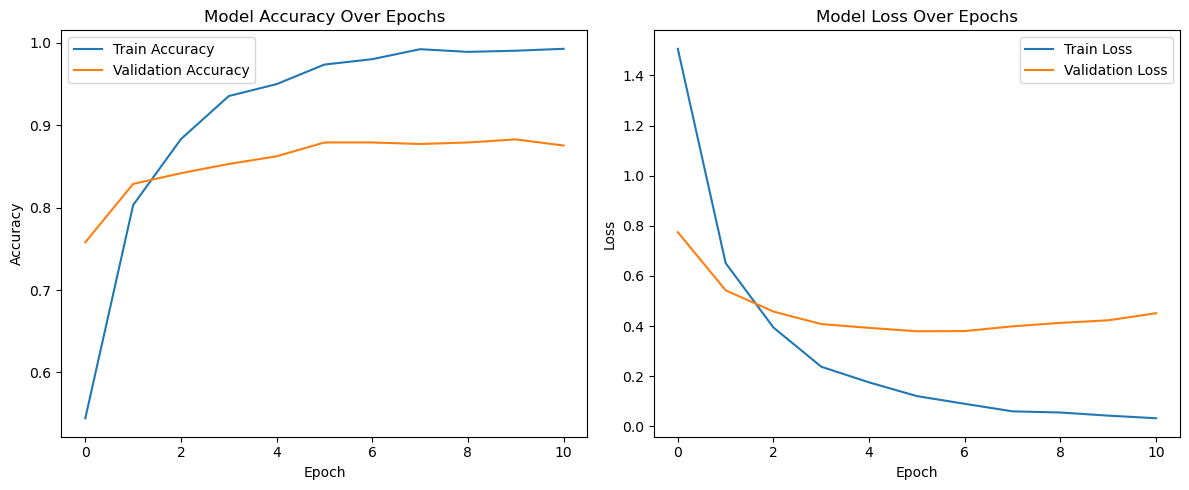

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


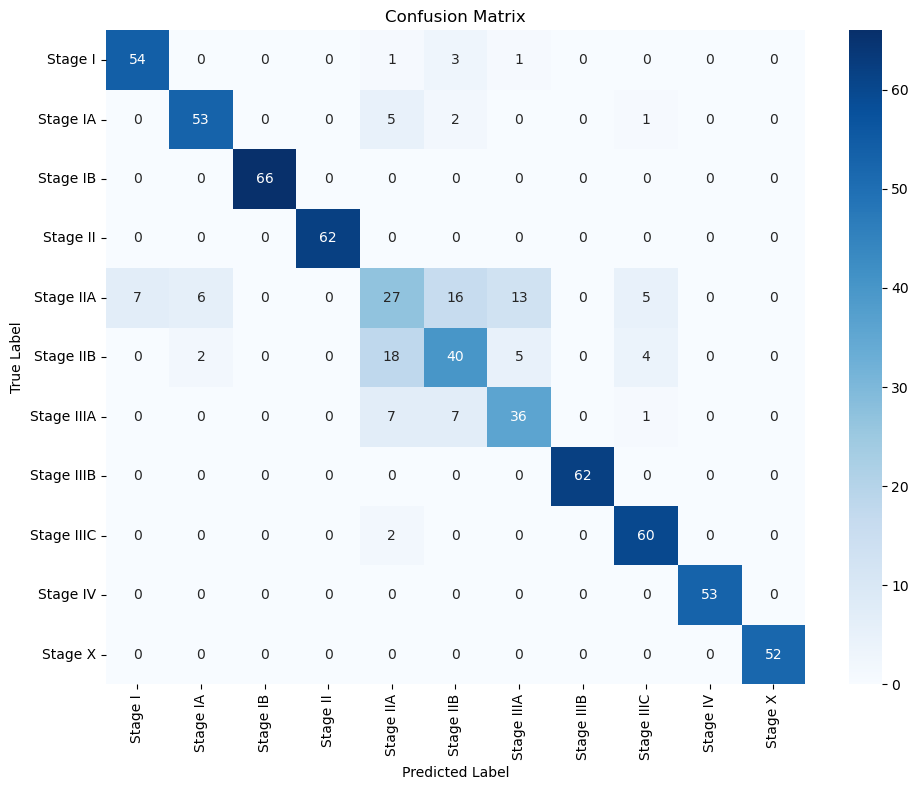

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
# 1. Convert one-hot encoded y_test back to class labels
y_true_classes = np.argmax(y_test, axis=1)

# 2. Predict using your model and get class predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 3. Decode class names using the saved label encoder
label_encoder = joblib.load("label_encoder.save")
present_class_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names,
            yticklabels=present_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


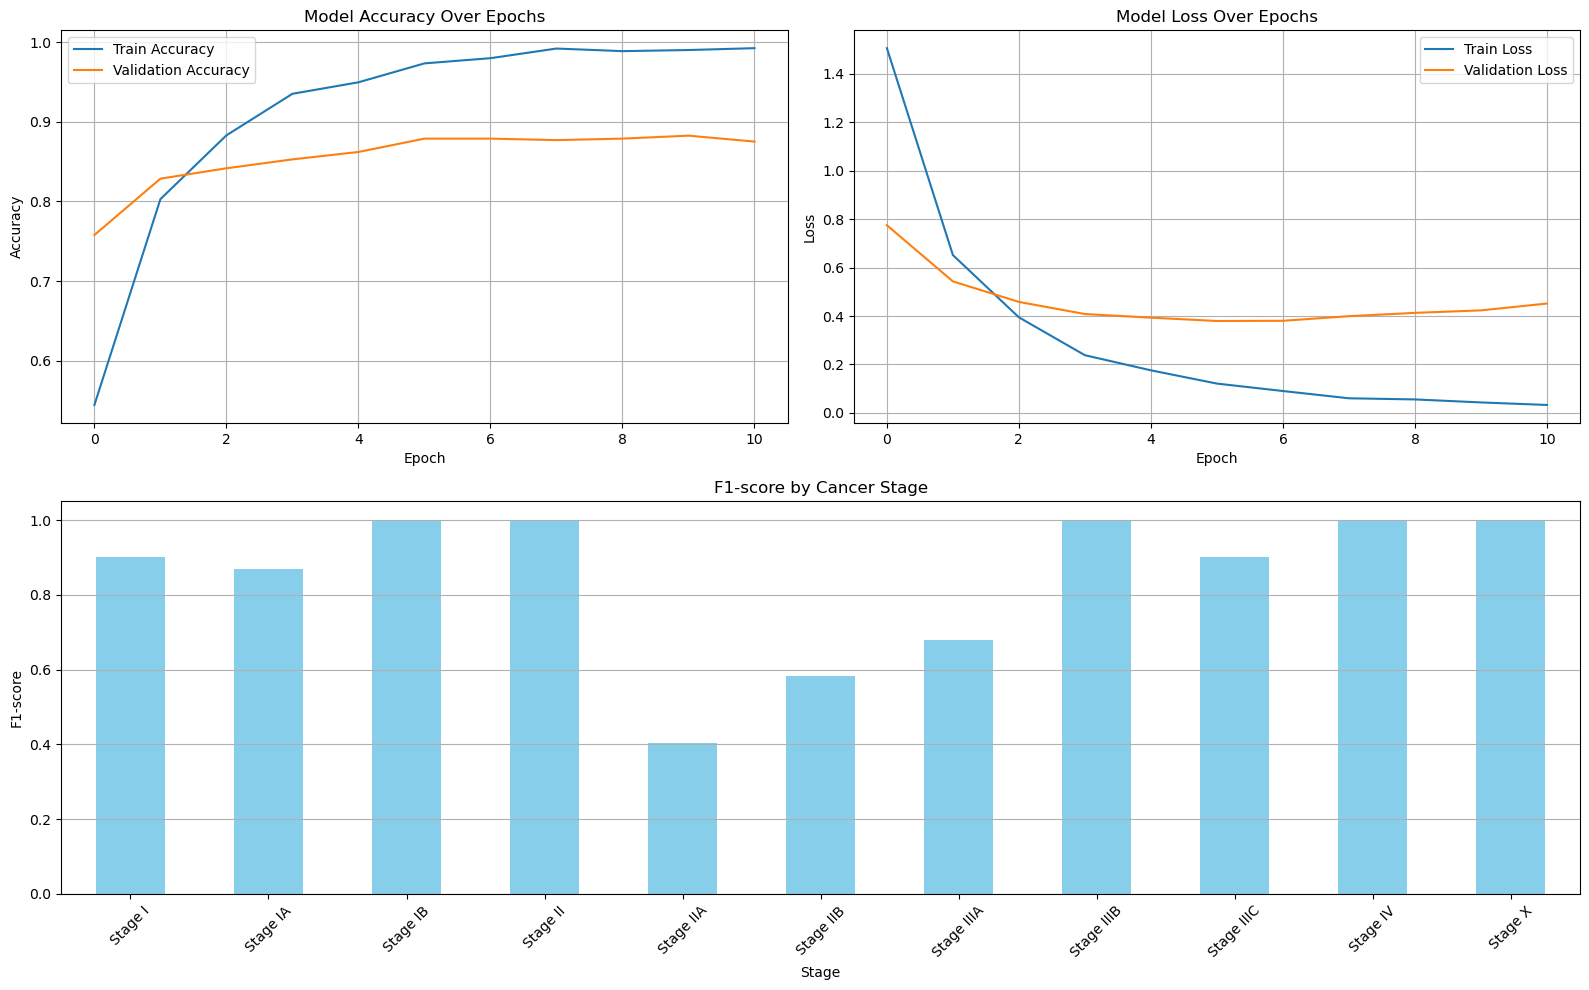

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
present_labels = label_encoder.transform(label_encoder.classes_)

# Build classification report DataFrame
report = classification_report(
    y_true_classes, y_pred_classes,
    labels=present_labels,
    target_names=present_class_names,
    output_dict=True
)
df_report = pd.DataFrame(report).transpose()

# Create the full figure with 2 rows: top with 2 side-by-side, bottom full-width
fig = plt.figure(figsize=(16, 10))

# Top left: Accuracy
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Top right: Loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Bottom full row: F1-score
ax3 = fig.add_subplot(2, 1, 2)  # spans both columns
df_report.iloc[:-3]['f1-score'].plot(kind='bar', color='skyblue', ax=ax3)
ax3.set_title('F1-score by Cancer Stage')
ax3.set_ylabel('F1-score')
ax3.set_xlabel('Stage')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y')

plt.tight_layout()
plt.show()


Now, we examine a combined visualization that illustrates the learning dynamics and classification strength of our vanilla neural network. This figure is organized into two main sections: the top row captures the model’s training history (accuracy and loss), and the bottom row displays the F1-scores across each breast cancer stage class a crucial performance metric in this multi-class, imbalanced dataset. In the top-left subplot, the accuracy curves show how well the model fits the data over time. We observe that training accuracy improves steadily, rising from around 45% in the first epoch to over 98% by epoch 11. Meanwhile, validation accuracy increases more moderately, plateauing just below 90%. This trend indicates that the model is learning generalizable patterns in the data without immediately overfitting. However, the growing gap between training and validation accuracy after epoch 5 suggests that the model is starting to over-specialize on the training set — a known risk in deep learning, especially with high-capacity models trained on finite data.

The top-right plot shows a similar pattern in terms of loss. Both training and validation losses decrease sharply during the early epochs, reflecting rapid convergence. After this point, training loss continues to fall toward zero, but validation loss levels off and begins to slightly rise. This inflection point confirms the beginning of overfitting. Thankfully, regularization techniques like dropout, early stopping, and learning rate reduction were integrated into the model’s training loop to mitigate this and halt the training process before the model fully memorizes the training data. The F1-score bar chart in the second row presents a breakdown of classification performance across all 13 cancer stages. The F1-score combines precision and recall, making it ideal for evaluating model performance on imbalanced classes where accuracy alone can be misleading. In this plot, we see that the model performs exceptionally well on several stages, achieving F1-scores close to 1.0. However, performance varies across the board.

generate sample

In [25]:
import pandas as pd

# Load full dataset
df = pd.read_csv("fina_Stage_unaugmented.csv", low_memory=False)

# Drop NaN and duplicates (same cleaning as training)
df = df.drop_duplicates(subset='Samples')
df = df.dropna(subset=['Stage'])

# Drop columns not used in the final model
drop_cols = [
    'Samples', 'submitter_id', 'barcode', 'Unnamed: 0', 'sample_id',
    'sample', 'sample_submitter_id', 'patient', 'paper_patient',
    'diagnosis_id', 'bcr_patient_barcode', 'pathology_report_uuid',
    'treatments', 'Stage'  # don't include target when predicting
]
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Keep only numeric columns
df = df.select_dtypes(include=[float, int])
df.replace([np.inf, -np.inf], pd.NA, inplace=True)
df.dropna(inplace=True)

# Pick 1 random sample and save
sample = df.sample(n=1)
sample.to_csv("random_sample3.csv", index=False)
print("✅ Saved 1 random sample to random_sample.csv")


✅ Saved 1 random sample to random_sample.csv


In [26]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model


sample = pd.read_csv("random_sample3.csv")


scaler = joblib.load("scaler.save")
pca = joblib.load("pca.save")
label_encoder = joblib.load("label_encoder.save")
model = load_model("vanilla_nn_brca_model.keras")

sample_scaled = scaler.transform(sample)  
sample_pca = pca.transform(sample_scaled)

pred_probs = model.predict(sample_pca)
pred_index = np.argmax(pred_probs)
pred_class = label_encoder.inverse_transform([pred_index])[0]

print(f"🔍 Predicted Stage: {pred_class}")
print("\n📊 Stage Probabilities:")
for stage, prob in zip(label_encoder.classes_, pred_probs[0]):
    print(f"{stage}: {prob*100:.2f}%")

🔍 Predicted Stage: Stage IIIA

📊 Stage Probabilities:
Stage I: 0.00%
Stage IA: 0.24%
Stage IB: 0.00%
Stage II: 0.00%
Stage IIA: 1.15%
Stage IIB: 5.02%
Stage IIIA: 93.57%
Stage IIIB: 0.01%
Stage IIIC: 0.00%
Stage IV: 0.00%
Stage X: 0.00%


In [26]:
print(list(pd.read_csv("test_sample.csv").columns))

['Samples', 'oct_embedded', 'preservation_method', 'days_to_collection', 'initial_weight', 'pathology_report_uuid', 'synchronous_malignancy', 'laterality', 'treatments', 'tissue_or_organ_of_origin', 'age_at_diagnosis', 'primary_diagnosis', 'prior_malignancy', 'year_of_diagnosis', 'prior_treatment', 'method_of_diagnosis', 'ajcc_pathologic_t', 'morphology', 'ajcc_pathologic_n', 'ajcc_pathologic_m', 'icd_10_code', 'sites_of_involvement', 'race', 'ethnicity', 'vital_status', 'age_at_index', 'days_to_birth', 'demographic_id', 'age_is_obfuscated', 'paper_Included_in_previous_marker_papers', 'paper_vital_status', 'paper_days_to_birth', 'paper_days_to_last_followup', 'paper_age_at_initial_pathologic_diagnosis', 'paper_pathologic_stage', 'paper_BRCA_Subtype_PAM50', 'paper_CNV.Clusters', 'paper_Mutation.Clusters', 'paper_DNA.Methylation.Clusters', 'paper_mRNA.Clusters', 'paper_miRNA.Clusters', 'paper_PARADIGM.Clusters', 'TMEM220', 'SCN4B', 'CYYR1', 'LINC00478', 'MIR497HG', 'SPRY2', 'CACHD1', 'SH

## KNN

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load and prepare dataset
df = pd.read_csv('fina_Stage_unaugmented.csv', low_memory=False)
df = df.drop_duplicates(subset='Samples')
df = df.dropna(subset=['Stage'])

y = df['Stage']
drop_cols = [
    'site_of_resection_or_biopsy', 'tumor_descriptor', 'sample_type_id', 'definition', 'primary_site',
    'name', 'disease_type', 'shortLetterCode', 'sample_type', 'project_id', 'classification_of_tumor',
    'specimen_type', 'state', 'is_ffpe', 'tissue_type', 'composition', 'paper_Tumor.Type', 'gender',
    'days_to_diagnosis', 'releasable', 'diagnosis_is_primary_disease', 'released'
]
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
X = X.select_dtypes(include=[np.number])

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
#smote due to some stages lacking samples
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

#to reduce the dimentiality
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

y_true = y_test
y_pred_classes = y_pred
y_true_classes = y_test

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")

print("Classification Report:\n")
present_labels = np.unique(y_true_classes)
present_class_names = label_encoder.classes_[present_labels].astype(str)

print(classification_report(
    y_true_classes, y_pred_classes,
    labels=present_labels,
    target_names=present_class_names
))


report_df.to_csv("knn_report_smote_pca.csv", index=True)
conf_df.to_csv("knn_confusion_matrix_smote_pca.csv", index=True)
print("Report and confusion matrix saved.")



Training Accuracy: 0.8666
Test Accuracy: 0.7958

Classification Report:

              precision    recall  f1-score   support

     Stage I       0.69      0.90      0.78        61
    Stage IA       0.51      0.84      0.63        61
    Stage IB       1.00      1.00      1.00        61
    Stage II       1.00      1.00      1.00        61
   Stage IIA       0.41      0.11      0.18        61
   Stage IIB       0.48      0.34      0.40        61
  Stage IIIA       0.68      0.64      0.66        61
  Stage IIIB       0.97      1.00      0.98        61
  Stage IIIC       0.85      0.92      0.88        61
    Stage IV       1.00      1.00      1.00        61
     Stage X       1.00      1.00      1.00        61

    accuracy                           0.80       671
   macro avg       0.78      0.80      0.77       671
weighted avg       0.78      0.80      0.77       671

Report and confusion matrix saved.
